In [373]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [ ]:
#~20 minutes to load everything 

In [717]:
metaDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEn.csv", lineterminator="\n")

#load in the entities for the full transcripts 
#OLD
transcriptEnts = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/transcripts/transcriptNEs.csv", sep="\t", names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

#load in entities for the first parts of the transcripts
#first500Ents = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podIntroductions/floydMonth500wordNEs.csv", names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")



In [375]:
epDescEnts = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/epDescriptions/epDescriptionNEs.csv", sep="\t", names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

In [376]:
#load in the entities for the descriptions 
descEntDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podDescriptions/floydMonthNEs.tsv", sep="\t",
                        names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

#introDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/floydIntroductions.tsv", sep="\t", names=["potentialOutPath", "first500"]) 

transcriptDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/allTranscripts.tsv", sep="\t", names=["potentialOutPath", "transcript"], lineterminator="\n")

In [ ]:
#check on the "potentialOutPath" column 

In [ ]:
"""
random info
we have 828 gb of data in transcripts + prosodic information right now
"""

## Clean Each Dataframe

In [377]:
print(f"transcript df shape:{transcriptDf.shape}") 
transDups = transcriptDf[transcriptDf.duplicated(subset=["potentialOutPath"], keep=False)]

transcript df shape:(601207, 2)


In [378]:
"""
out of the 601,207 transcripts, 18,124 of the paths are duplicates.
(that's 3.01%), but only half of those get dropped 

not exactly sure where these come from is the thing... 
"""

"\nout of the 601,207 transcripts, 18,124 of the paths are duplicates.\n(that's 3.01%), but only half of those get dropped \n\nnot exactly sure where these come from is the thing... \n"

In [399]:
#fix the path so it doesn't include /shared/3/... etc... 
transcriptDf["potentialOutPath"] = transcriptDf["potentialOutPath"].apply(lambda x: x[67:])

In [400]:
#this shows that they're all exact duplicates on both the outpath and the transcript
print(transDups[transDups.duplicated(keep=False)].sort_values("potentialOutPath").shape)
print(transDups.shape)

(18124, 2)
(18124, 2)


In [401]:
scriptDups = transcriptDf[transcriptDf.duplicated(subset=["transcript"], keep=False)]
scriptDups.shape

(53211, 2)

In [402]:
"""
Duplicated transcripts.. 
we have 53,211 transcripts that are duplicates, which is 8.85%
we only need to remove half of these which gives 4.425% that are removed \

about one third of the duplicates are very short 

from qualitative review of dups we are getting some amount of music-only and blank audio, which could have something
to do with this problem 

i.e. "content [silence]" or "content [music]" 
"""

'\nDuplicated transcripts.. \nwe have 53,211 transcripts that are duplicates, which is 8.85%\nwe only need to remove half of these which gives 4.425% that are removed \nabout one third of the duplicates are very short \n\nfrom qualitative review of dups we are getting some amount of music-only and blank audio, which could have something\nto do with this problem \n\ni.e. "content [silence]" or "content [music]" \n'

In [403]:
#what is the length of these duplicate transcripts 
scriptDups["scriptLen"] = scriptDups["transcript"].apply(lambda x: len(x.split()))

/tmp/ipykernel_1749053/217925127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scriptDups["scriptLen"] = scriptDups["transcript"].apply(lambda x: len(x.split()))


In [404]:
53211 / 601207

0.08850695351185199

In [405]:
#do we have any NaN or None values in the transcripts or outPaths? 
#drop duplicates in transcript df
#note that this removes duplicates on the (outPath, transcript) columns
#which ones we keep doesn't matter because they're perfect duplicates of eachother
transcriptDf = transcriptDf.drop_duplicates(keep="first")

#only one row!? 
#and no NaN values for potentialOutPath
print(transcriptDf[transcriptDf["transcript"].isna()].shape)
print(transcriptDf[transcriptDf["potentialOutPath"].isna()].shape) 

#no "None" values 
transcriptDf[transcriptDf["transcript"] == None]
transcriptDf[transcriptDf["potentialOutPath"] == None]

#drop the na's (one row atm) 
transcriptDf = transcriptDf.dropna()

#are there transcripts that are too short? 
transcriptDf["wCount"] = transcriptDf["transcript"].apply(lambda x: len(x.split()))

(1, 2)
(0, 2)


In [406]:
print(f'average word count: {np.mean(transcriptDf["wCount"])}') 
print(f'median word count: {np.median(transcriptDf["wCount"])}') 
print(f'total word count: {sum(transcriptDf["wCount"])}')

average word count: 4204.260490577457
median word count: 3673.0
total word count: 2486849510


In [407]:
#do we have transcripts that have no real content?
#we had about 5,800 transcripts with word counts under or equal to 10
print(transcriptDf[transcriptDf["wCount"] > 10].shape)

#leave this for another script
#transcriptDf = transcriptDf[transcriptDf["wCount"] > 10]

#duplicates on potentialOutPath in metadata
print(metaDf[metaDf.duplicated(subset=["potentialOutPath"], keep=False)].shape) 

#drop duplicates on potential out path 
metaDf = metaDf.drop_duplicates(subset=["potentialOutPath"], keep="first")

(586225, 3)
(32296, 57)


In [408]:
#for parsing the metadata durations 
def parseDurations(inDuration): 
    #if na value, just return na value 
    if inDuration != inDuration: 
        return inDuration 
    
    inDuration = str(inDuration)
    inDuration = re.sub("[A-z]", "", inDuration)
    colonCount = inDuration.count(":")
    
    try: 
        
        #parse different strings into number of seconds 
        if colonCount == 0: 
            return int(inDuration)

        elif colonCount == 1: 
            mins, seconds = [int(item) for item in inDuration.split(":")]
            return (60*mins) + seconds 

        elif colonCount == 2: 
            hours, mins, seconds = [int(item) for item in inDuration.split(":")]
            return (hours*60*60) + (mins*60) + seconds
        else: 
            return np.nan
    except: 
        return np.nan

In [409]:
""" 
We have a very small (like 300) number of podcasts that are over 10 hours. 
No discernable reason why, so we must assume a data entry error... 
"""

' \nWe have a very small (like 300) number of podcasts that are over 10 hours. \nNo discernable reason why, so we must assume a data entry error... \n'

In [410]:
#now parse durations
metaDf["parsedDuration"] = metaDf["duration"].apply(parseDurations) 

#2% of the values parsed are na 
print(np.mean(metaDf["parsedDuration"].isna()))

metaDf["hours"] = metaDf["parsedDuration"] / (60 * 60) 

0.02080318684904721


In [720]:
#keeping only the metadata for which we have transcripts 
df = pd.merge(transcriptDf, metaDf, on="potentialOutPath", how="left") 
df.shape

(591507, 61)

In [442]:
#three entity Dfs 
#transcriptEnts, epDescEnts, descEntDf

In [413]:
"""
sampling entDf and descEntDf, they both seem fine... 
we do get duplicates though, which is odd. I assume this comes from 
reading the same file twice when running NER? didn't drop duplicates before doing NER potentially?

entDf dups -> 150,000
desEntDf dups -> 40,000 
(both are tiny fractions of all entities extracted) 
"""
sum(transcriptEnts.duplicated()) 
sum(epDescEnts.duplicated())
sum(descEntDf.duplicated())

transcriptEnts = transcriptEnts.drop_duplicates() 
epDescEnts = epDescEnts.drop_duplicates() 
descEntDf = descEntDf.drop_duplicates() 

In [721]:
transcriptEnts = transcriptEnts.drop_duplicates()

In [414]:
#df = df.drop(columns=['ent_x', 'start_x', 'end_x', 'type_x', 'ent_y', 'start_y','end_y', 'type_y'])

In [722]:
#add the entities in, but first check on duplicates 
transcriptEnts = transcriptEnts.groupby(by="potentialOutPath").agg(list)
transcriptEnts = transcriptEnts.reset_index() 

In [723]:
transcriptEnts = transcriptEnts.rename(columns={"ent":"transEnts", "start":"transStarts", "end":"transEnds", "type":"transTypes"})

In [748]:
#len("/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth")
transcriptEnts["potentialOutPath"] = transcriptEnts["potentialOutPath"].apply(lambda x: x[67:])

In [749]:
transcriptEnts.head() 

,potentialOutPath,transEnts,transStarts,transEnds,transTypes
0,/119ministries.podomatic.com/02/https119minist...,"[Paw Shop Points, weekly, week, Paw Shop Point...","[38, 79, 105, 112, 138, 154, 172, 201, 219, 28...","[53, 85, 109, 126, 143, 160, 180, 210, 228, 29...","[ORG, DATE, DATE, ORG, ORG, LANGUAGE, LOC, PER..."
1,/119ministries.podomatic.com/02/https119minist...,"[Posh Off Points, weekly, week, Posh Off Point...","[38, 78, 104, 111, 137, 157, 175, 212, 227, 28...","[53, 84, 108, 125, 146, 163, 185, 215, 230, 29...","[ORG, DATE, DATE, ORG, ORG, LANGUAGE, LOC, CAR..."
2,/163.172.97.59/pm/http163.172.97.59ndpndp14mmo...,"[every day, Today, 12, 10, two, first, Ali, Al...","[35, 46, 73, 197, 205, 234, 253, 466, 608, 778...","[44, 51, 75, 199, 208, 239, 256, 469, 611, 786...","[DATE, DATE, CARDINAL, CARDINAL, CARDINAL, ORD..."
3,/1bx8jry.podcaster.de/NE/https1bx8jry.podcaste...,"[first, Kenneth Fiddlepage, today, one, IMCAG,...","[91, 141, 170, 297, 466, 953, 1193, 1294, 1381...","[96, 159, 175, 300, 471, 956, 1198, 1303, 1385...","[ORDINAL, PERSON, DATE, CARDINAL, ORG, ORG, OR..."
4,/1ecf4a91e3b66e47e3c778560c25393e65036989e83e4...,"[The Invisible String, Patrice Carst, this mor...","[301, 325, 379, 393, 404, 560, 626, 727, 890, ...","[321, 338, 391, 399, 410, 565, 629, 733, 894, ...","[WORK_OF_ART, PERSON, TIME, ORG, PERSON, PERSO..."


In [753]:
df = pd.merge(df, transcriptEnts, on="potentialOutPath", how="left") 

In [451]:
descEntDf = descEntDf.groupby(by="potentialOutPath").agg(list)
descEntDf = descEntDf.reset_index() 

In [452]:
descEntDf.head() 

,potentialOutPath,descEnts,descStarts,descEnds,descTypes
0,//02/httptcf.theophil.usmedia20200607207E20Fea...,[TCF Sermons],[0],[11],[ORG]
1,//03/200531_Unclained.mp3MERGED,"[KSCO Pet Radio's, Sundays 12-2 PM]","[0, 425]","[16, 440]","[ORG, DATE]"
2,//10/10725MERGED,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."
3,//10/10728MERGED,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."
4,//10/10734MERGED,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."


In [418]:
descEntDf = descEntDf.rename(columns={"ent":"descEnts", "start":"descStarts", "end":"descEnds", "type":"descTypes"})

In [729]:
df = pd.merge(df, descEntDf, on="potentialOutPath", how="left") 

In [454]:
df.shape

(591507, 69)

In [447]:
descEntDf.head() 

,potentialOutPath,descEnts,descStarts,descEnds,descTypes
0,/www.buzzsprout.com/30/httpswww.buzzsprout.com...,Australian,14,24,NORP
1,/www.buzzsprout.com/30/httpswww.buzzsprout.com...,Simon Shapiro,43,56,PERSON
2,/www.buzzsprout.com/3y/httpswww.buzzsprout.com...,Australian,14,24,NORP
3,/www.buzzsprout.com/3y/httpswww.buzzsprout.com...,Simon Shapiro,43,56,PERSON
4,/www.buzzsprout.com/3r/httpswww.buzzsprout.com...,Australian,14,24,NORP


In [446]:
df.shape

(2017500, 69)

In [420]:
epDescEnts= epDescEnts.groupby(by="potentialOutPath").agg(list)
epDescEnts = epDescEnts.reset_index() 

In [440]:
len(epDescEnts["potentialOutPath"].unique())

1312920

In [421]:
epDescEnts = epDescEnts.rename(columns={"ent":"epDescEnts", "start":"epDescStarts", "end":"epDescEnds", "type":"epDescTypes"})

In [730]:
epDescEnts.head() 

,potentialOutPath,epDescEnts,epDescStarts,epDescEnds,epDescTypes
0,//02/atog042620.mp3MERGED,"[1, Carole Marks, Kathleen O'Keefe-Kavanos, 2,...","[0, 3, 21, 120, 123, 141, 268, 295, 317, 413, ...","[1, 15, 45, 121, 135, 165, 293, 307, 334, 416,...","[CARDINAL, PERSON, PERSON, CARDINAL, PERSON, P..."
1,//03/200531_Unclained.mp3MERGED,"[Terrence Gargiulo, UnChainedPODCAST, Central ...","[0, 19, 62, 89, 98, 147, 188, 382, 419, 723, 8...","[17, 35, 75, 93, 112, 154, 205, 409, 428, 748,...","[PERSON, ORG, LOC, ORG, ORG, CARDINAL, PERSON,..."
2,//0e/ReelAnimals20200505.mp3MERGED,"[this week, the Reel Animals Podcast, Contende...","[6, 29, 67, 90, 117, 162, 194, 399, 435, 452, ...","[15, 53, 82, 103, 144, 172, 200, 423, 448, 466...","[DATE, ORG, PERSON, PERSON, ORG, PERSON, PERSO..."
3,//10/10711MERGED,[Peter 2:4-10</p],[5],[20],[PERSON]
4,//10/10715MERGED,"[Peter, 2:11-3:7</p]","[5, 11]","[10, 22]","[PERSON, CARDINAL]"


In [731]:

df = pd.merge(df, epDescEnts, on="potentialOutPath", how="left") 

In [732]:
df = df.drop(columns=['Unnamed: 0']) 

In [733]:
#validating that we have as many rows in our dataframe as we do transcripts that we've processed 
df.shape

(591507, 72)

In [428]:
"""
We have some duplicates on the outPaths and these are not all identical in terms of
the (outPath, transcript) pair 
"""

'\nWe have some duplicates on the outPaths and these are not all identical in terms of\nthe (outPath, transcript) pair \n'

In [408]:
#get David's stuff 
print(sum(df.dropna(subset=["hours"])["hours"]))
print(np.mean(df.dropna(subset=["hours"])["hours"]))
print(np.median(df.dropna(subset=["hours"])["hours"]))

259438.1211111099
0.442582914290924
0.41583333333333333


In [418]:
min(df["cleanDates"]) 

'2020-05-11 00:00:00'

In [419]:
max(df["cleanDates"]) 

'2020-06-08 00:00:00+11:00'

In [415]:
259438 * 60

15566280

In [414]:
#number of episodes 
len(df["rssUrl"].unique())

187119

In [422]:
df.shape

(586225, 68)

Text(0.5, 1.0, 'ecdf: duration of collected podcasts')

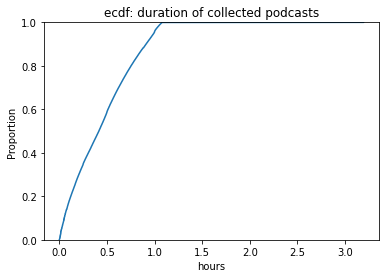

In [424]:
sns.ecdfplot(data=df, x="hours")
plt.title("ecdf: duration of collected podcasts") 

In [459]:
def cleanQuotes(inStr): 
    if inStr != inStr: 
        return inStr 
    outStr = re.sub('(?<!")"(?!")', ',',inStr) 
    return re.sub('"""', '"', outStr)[8:]

In [460]:
from tqdm import tqdm

In [437]:
epDescEnts.shape

(1312920, 5)

In [735]:
outList = []
for i, row in tqdm(df.iterrows()): 
    outList.append(cleanQuotes(row["transcript"])[8:])

591507it [15:12, 648.25it/s] 


In [466]:
outList[0]

"I'm Simon Shapiro and this is Sing Out Speak Out. Here I give you the philosophies, ideas and songs I've been working on for many years but until now I've shared just too few of because I've been afraid of you and worse I've been afraid of me. My will to connect with you and share the best of me has grown greater than any fear and that's why I am compelled to Sing Out Speak Out. Well hello everyone and welcome to Sing Out Speak Out episode number 20. I know crazy, it's going fast this crazy year that we are having 2020. I know for a lot of people the hard lockdown and the restrictions due to COVID-19 are still in full force and in Australia we are very lucky that we've managed to squash that curve for now due I think in part because we have a smaller population and we had advanced warning of what was happening in other countries so I think that held us in good stead but we're not over it yet of course and we're not gloating in any way whatsoever. But I know it can be tough when you're

In [736]:
df["transcript"] = outList

In [738]:
#need to clean repetitive/non-english? 
df.shape

(591507, 72)

In [756]:
df.head() 

,potentialOutPath,transcript,wCount,rssUrl,epTitle,epDescription,duration,pubDate,copyright,itunes:type,...,descEnds,descTypes,epDescEnts,epDescStarts,epDescEnds,epDescTypes,transEnts,transStarts,transEnds,transTypes
0,/www.buzzsprout.com/3y/httpswww.buzzsprout.com...,I'm Simon Shapiro and this is Sing Out Speak O...,766,https://feeds.buzzsprout.com/783020.rss,Today Is Yesterday,"<p>Simon introduces track 4, of the newly rele...",416,"Sun, 31 May 2020 21:00:00 +1000",NaN,NaN,...,"[24, 56]","[NORP, PERSON]","[Simon, 4, KisTone, Yesterday&apos;.</p]","[3, 26, 52, 83]","[8, 27, 59, 102]","[PERSON, CARDINAL, FAC, PERSON]","[Simon Shapiro, Sing Out Speak Out, many years...","[4, 30, 125, 362, 417, 451, 485, 520, 639, 112...","[17, 48, 135, 380, 435, 453, 500, 524, 648, 11...","[PERSON, WORK_OF_ART, DATE, WORK_OF_ART, WORK_..."
1,/www.buzzsprout.com/3r/httpswww.buzzsprout.com...,I'm Simon Shapiro and this is Sing Out Speak O...,599,https://feeds.buzzsprout.com/783020.rss,Saturn Return,"<p>This week, Simon introduces track 2- Saturn...",476,"Sun, 24 May 2020 19:00:00 +1000",NaN,NaN,...,"[24, 56]","[NORP, PERSON]","[This week, Simon, Saturn Return of, KisTone, ...","[3, 14, 40, 61, 188]","[12, 19, 56, 68, 197]","[DATE, PERSON, WORK_OF_ART, FAC, ORG]","[Simon Shapiro, Sing Out Speak Out, many years...","[4, 30, 125, 362, 406, 469, 497, 517, 532, 653...","[17, 48, 135, 380, 422, 478, 502, 525, 549, 65...","[PERSON, WORK_OF_ART, DATE, WORK_OF_ART, DATE,..."
2,/www.buzzsprout.com/30/httpswww.buzzsprout.com...,I'm Simon Shapiro and this is Sing Out Speak O...,699,https://feeds.buzzsprout.com/783020.rss,Quarterlife Crisis,<p>Big news week. The band Simon lived in the ...,509,"Sun, 17 May 2020 20:00:00 +1000",NaN,NaN,...,"[24, 56]","[NORP, PERSON]","[Simon, USA, KisTone, 12 years, Simon, 1, Cris...","[27, 46, 56, 101, 123, 196, 211]","[32, 49, 63, 109, 128, 197, 221]","[PERSON, GPE, PRODUCT, DATE, PERSON, CARDINAL,...","[Simon Shapiro, Sing Out Speak Out, many years...","[4, 30, 125, 362, 425, 459, 568, 656, 668, 909...","[17, 48, 135, 380, 443, 464, 577, 667, 680, 91...","[PERSON, WORK_OF_ART, DATE, WORK_OF_ART, WORK_..."
3,/mcdn.podbean.com/e_/httpsmcdn.podbean.commfwe...,"[Music] Welcome to, ""Brazing Education"""" with ...",11152,https://brazeneducation.podbean.com/feed.xml,BE: Episode 37 - The Benefits of Homeschooling...,<p>Listen as Educator Barnes talks to Natalie ...,57:00,"Sun, 24 May 2020 21:39:35 -0400",NaN,NaN,...,NaN,NaN,"[Barnes, Natalie Pipkin]","[22, 38]","[28, 52]","[PERSON, PERSON]","[Music] Welcome, Barnes, today, Natalie Pippki...","[1, 265, 282, 312, 345, 399, 410, 968, 1142, 1...","[15, 271, 287, 327, 366, 408, 413, 975, 1163, ...","[WORK_OF_ART, PERSON, DATE, PERSON, ORG, PERSO..."
4,/dts.podtrac.com/e3/httpdts.podtrac.comredirec...,"Hi, this is Eli Ortiz Oakley, Chancellor of th...",3898,https://feeds.soundcloud.com/users/soundcloud:...,Episode 33 'California’s Higher Education Lan...,It’s no secret that the COVID-19 pandemic has ...,00:25:58,"Fri, 22 May 2020 18:25:44 +0000",NaN,NaN,...,"[25, 72, 196, 302, 351]","[PERSON, ORG, PERSON, DATE, GPE]","[Eloy Ortiz Oakley, Monica Lozano, the College...","[122, 153, 175, 236]","[139, 166, 205, 246]","[PERSON, PERSON, ORG, GPE]","[Eli Ortiz Oakley, the California Community Co...","[12, 44, 122, 185, 231, 267, 352, 619, 694, 82...","[28, 77, 155, 190, 244, 297, 362, 629, 701, 83...","[PERSON, ORG, ORG, DATE, PERSON, ORG, GPE, GPE..."


In [1]:
df.to_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthData.jsonl", orient="records", lines=True)

NameError: name 'df' is not defined